In [1]:
# Date 10/23/2019 

# import PCA
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from rerf.urerf import UnsupervisedRandomForest
from sklearn.cluster import AgglomerativeClustering

# import rand
from sklearn.random_projection import GaussianRandomProjection
rng = np.random.RandomState(42)
noise = rng.rand(150,4) # create the distributed noise

In [2]:
#plt.scatter(noise[:,1],noise[:,2],s=15,c='None',edgecolor='blue') # try seed rnd 
#plt.title('1 Point cluster, N=500')
#plt.show()

In [3]:
# import E
from scipy.stats import multivariate_normal
import random as rn
import eif as iso #download Isolation Forest
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage 
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed #create the same random
import pandas as pd 

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from rerf.urerf import UnsupervisedRandomForest

In [4]:
iris = datasets.load_iris()
X1 = iris.data
X1.shape
X = iris.data + noise*0 # no noise
#print(X.shape)
clf = UnsupervisedRandomForest(feature_combinations='auto', max_depth=None,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=1000, n_jobs=None,
                         projection_matrix='RerF', random_state=0)
clf.fit(X)
sim_mat = clf.transform()
X1.shape

(150, 4)

In [5]:
from sklearn.decomposition import PCA
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

pca = PCA(n_components= 2)
principalComponents = pca.fit_transform(sim_mat)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2']) # new PCA component for Iris

finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
#principalDf.values -> convert DataFrame to array

In [6]:
# Iris Data (2 component PCA)
principalDf.tail()

,principal component 1,principal component 2
145,-0.331381,0.551189
146,-0.274696,-0.006689
147,-0.325678,0.428335
148,-0.311984,0.604624
149,-0.303549,0.038506


In [7]:
# Generate Outliers
outlierDf = pd.DataFrame([[-0.8, 0.4], [-0.8, -0.4],[0.9,-0.1]], 
                         columns = ['principal component 1', 'principal component 2'])
outlierDf 

,principal component 1,principal component 2
0,-0.8,0.4
1,-0.8,-0.4
2,0.9,-0.1


In [8]:
# Adding Outlier
with_outlierDf= pd.concat([principalDf, outlierDf],ignore_index=True)

In [9]:
# create label
labelArray=np.append(np.zeros(150), [1, 1, 1], axis = 0)
labelDf=pd.DataFrame(data = labelArray
             , columns = ['label']) # new PCA component for Iris
labelDf.tail()

# adding label into the Df
with_labelDf= pd.concat([with_outlierDf, labelDf],axis = 1)

In [10]:
# prediction
F0 = iso.iForest(with_outlierDf.values, ntrees = 100, sample_size = 100, ExtensionLevel = 0) # numpy.ndarray
F1 = iso.iForest(with_outlierDf.values, ntrees = 100, sample_size = 100, ExtensionLevel = 1)

# calculate anomaly scores
S0 = F0.compute_paths(X_in = with_outlierDf.values)
S1 = F1.compute_paths(X_in = with_outlierDf.values)
# sort the scores
ss0 = np.argsort(S0)
ss1 = np.argsort(S1)

# retrieve indices of anomalous observations
anomalies_ratio=3/153
anomalies_ratio
indices0 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):] 
indices1 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):]

# create predictions 
y_pred0 = np.zeros(153)  # '0' array
y_pred0[indices0] = 1    # set some to '1'

y_pred1 = np.zeros(153)
y_pred1[indices1] = 1


In [11]:
# adding the prediction into Df
label0Df=pd.DataFrame(data = y_pred0
             , columns = ['IFpred']) # new PCA component for Iris
label1Df=pd.DataFrame(data = y_pred1
             , columns = ['EFpred']) # new PCA component for Iris
with_predDf= pd.concat([with_labelDf, label0Df,label1Df],axis = 1)
with_predDf.tail()

,principal component 1,principal component 2,label,IFpred,EFpred
148,-0.311984,0.604624,0.0,0.0,0.0
149,-0.303549,0.038506,0.0,0.0,0.0
150,-0.800000,0.400000,1.0,1.0,1.0
151,-0.800000,-0.400000,1.0,1.0,1.0
152,0.900000,-0.100000,1.0,1.0,1.0


In [12]:
IFscore = adjusted_rand_score(with_labelDf.label.values, y_pred0 )
EFscore =adjusted_rand_score(with_labelDf.label.values, y_pred1 )

print('Isolation Forest Score : ', IFscore)
print('Extended Isolation Forest Score : ', EFscore)

Isolation Forest Score :  1.0
Extended Isolation Forest Score :  1.0


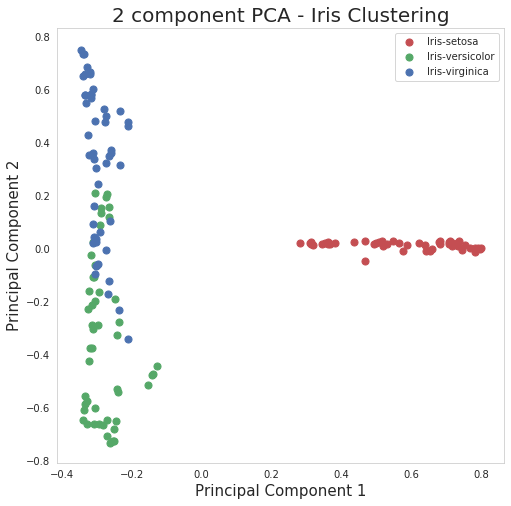

In [13]:
# 2 component PCA - Iris Clustering
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA - Iris Clustering', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

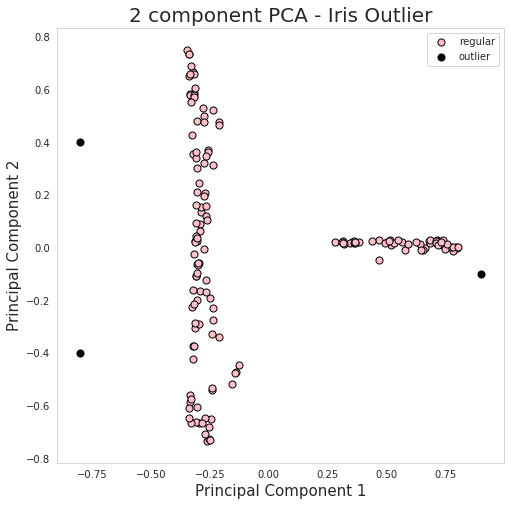

In [14]:
# 2 component PCA - Iris Outlier
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA - Iris Outlier', fontsize = 20)
label = [0,1]
colors = ['pink','black']
for target, color in zip(label,colors):
    indicesToKeep = with_labelDf['label'] == target
    ax.scatter(with_labelDf.loc[indicesToKeep, 'principal component 1']
               , with_labelDf.loc[indicesToKeep, 'principal component 2']
               , c = color, edgecolor='black'
               , s = 50)
ax.legend(['regular','outlier'])
ax.grid()

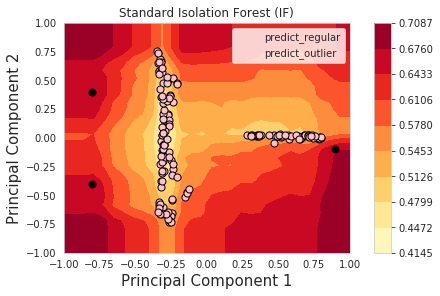

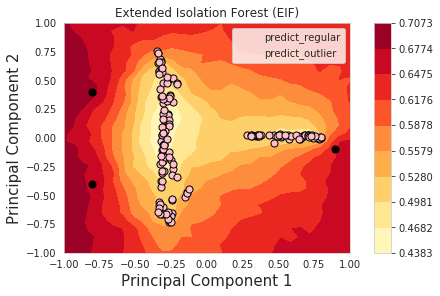

In [15]:

## (Outlier) Socre map s(x,n)
#>>> create a contour plot of score map
xx, yy = np.meshgrid(np.linspace(-1, 1, 30), np.linspace(-1, 1, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

fig1, ax1= plt.subplots(constrained_layout=True)
#ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS1 = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
cbar = fig1.colorbar(CS1)#
#cbar.ax1.set_ylabel('anomaly score')

#plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-1,1)
plt.ylim(-1, 1)

ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
target = [0,1]
colors = ['pink','black']
for target, color in zip(label,colors):
    indicesToKeep = with_predDf['IFpred'] == target
    ax1.scatter(with_predDf.loc[indicesToKeep, 'principal component 1']
               , with_predDf.loc[indicesToKeep, 'principal component 2']
               , c = color, edgecolor='black'
               , s = 50)
ax1.legend(['predict_regular','predict_outlier'])
ax1.grid()
plt.title('Standard Isolation Forest (IF)')



fig2, ax2= plt.subplots(constrained_layout=True)
#ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10)
CS2 = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
cbar = fig2.colorbar(CS2)#
#cbar.ax2.set_ylabel('anomaly score')

#plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-1,1)
plt.ylim(-1, 1)

ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
target = [0,1]
colors = ['pink','black']
for target, color in zip(label,colors):
    indicesToKeep = with_predDf['EFpred'] == target
    ax2.scatter(with_predDf.loc[indicesToKeep, 'principal component 1']
               , with_predDf.loc[indicesToKeep, 'principal component 2']
               , c = color, edgecolor='black'
               , s = 50)
ax2.legend(['predict_regular','predict_outlier'])
ax2.grid()

plt.title('Extended Isolation Forest (EIF)')


plt.show()


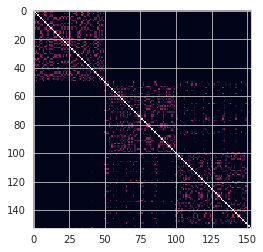

In [16]:
clf.fit(with_outlierDf.values)

sim_mat = clf.transform()
plt.imshow(sim_mat)